In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
import torchmetrics
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms, utils
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import albumentations as A
import torch.nn.functional as F
import pandas as pd
import nibabel as nib
from tqdm import tqdm

2024-03-28 17:59:35.583361: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-28 17:59:37.727745: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Extract dataset

In [2]:
! ls BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/ | head -5

BraTS20_Training_001
BraTS20_Training_002
BraTS20_Training_003
BraTS20_Training_004
BraTS20_Training_005


In [3]:
! ls BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/

BraTS20_Training_001_flair.nii	BraTS20_Training_001_t1.nii
BraTS20_Training_001_seg.nii	BraTS20_Training_001_t2.nii
BraTS20_Training_001_t1ce.nii


In [4]:
root = './BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
data = pd.read_csv(os.path.join(root, 'name_mapping.csv'))
data.head(5)

,Grade,BraTS_2017_subject_ID,BraTS_2018_subject_ID,TCGA_TCIA_subject_ID,BraTS_2019_subject_ID,BraTS_2020_subject_ID
0,HGG,Brats17_CBICA_AAB_1,Brats18_CBICA_AAB_1,NaN,BraTS19_CBICA_AAB_1,BraTS20_Training_001
1,HGG,Brats17_CBICA_AAG_1,Brats18_CBICA_AAG_1,NaN,BraTS19_CBICA_AAG_1,BraTS20_Training_002
2,HGG,Brats17_CBICA_AAL_1,Brats18_CBICA_AAL_1,NaN,BraTS19_CBICA_AAL_1,BraTS20_Training_003
3,HGG,Brats17_CBICA_AAP_1,Brats18_CBICA_AAP_1,NaN,BraTS19_CBICA_AAP_1,BraTS20_Training_004
4,HGG,Brats17_CBICA_ABB_1,Brats18_CBICA_ABB_1,NaN,BraTS19_CBICA_ABB_1,BraTS20_Training_005


In [5]:
imgpath = {
    'seg': [],    
    't1': [],
    't1ce': [],
    't2': [],
    'flair': []
}

# load image paths in dictionary
for x in data['BraTS_2020_subject_ID']:
    patient=os.path.join(root,x)
    for name in imgpath:
        imgpath[name].append(os.path.join(patient, x+f'_{name}.nii'))
imgpath['seg'][:5]

['./BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii',
 './BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_seg.nii',
 './BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_seg.nii',
 './BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_004/BraTS20_Training_004_seg.nii',
 './BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_005/BraTS20_Training_005_seg.nii']

In [6]:
def loadimg(imgpath):
    return nib.load(imgpath).get_fdata()

def cropcentre(imgslice,cropx,cropy):
    y,x = imgslice.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return imgslice[starty:starty+cropy,startx:startx+cropx]

def normalizeslice(imgslice):
    return (imgslice-imgslice.mean()) / imgslice.std()

In [7]:
! mkdir dataset
! mkdir dataset/t1
! mkdir dataset/t1ce
! mkdir dataset/t2
! mkdir dataset/flair
! mkdir dataset/seg

mkdir: cannot create directory ‘dataset’: File exists
mkdir: cannot create directory ‘dataset/t1’: File exists
mkdir: cannot create directory ‘dataset/t1ce’: File exists
mkdir: cannot create directory ‘dataset/t2’: File exists
mkdir: cannot create directory ‘dataset/flair’: File exists
mkdir: cannot create directory ‘dataset/seg’: File exists


In [46]:
numOfImgsSaved = 0
imgs = {}
imgslice = {}
imagestosave = 6000

for i in (range(len(imgpath['seg']))):
    if numOfImgsSaved >= imagestosave:
        break
    for name in imgpath:
        imgs[name] = loadimg(imgpath[name][i])
    
    for j in range(155):
        if numOfImgsSaved >= imagestosave:
            break
        for name in imgs:
            imgslice[name] = imgs[name][:,:,j]
            imgslice[name] = cropcentre(imgslice[name], 192, 192)

        if imgslice['seg'].max() > 0:
            for name in ['t1','t2','t1ce','flair']:
                imgslice[name] = normalizeslice(imgslice[name])
            for name in imgslice:
                np.save(f'./dataset/{name}/img_{numOfImgsSaved}.npy', imgslice[name])
            numOfImgsSaved += 1



In [8]:
! du -h dataset

3.3G	dataset/t1ce
3.3G	dataset/t2
3.3G	dataset/t1
3.3G	dataset/flair
2.8G	dataset/seg
16G	dataset


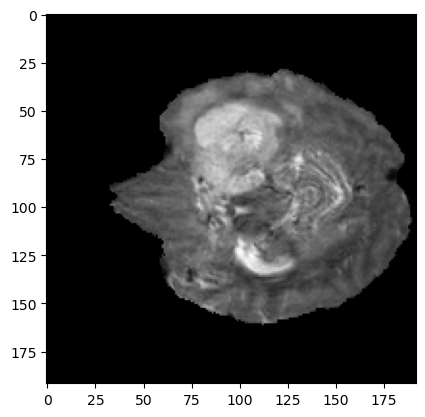

In [7]:
x = np.load('dataset/t2/img_25.npy')
plt.imshow(x, cmap='gray')

# Dataset

In [2]:
class Dataset(Dataset):
    def __init__(self, datapath='./dataset/', augmentation=None):
        self.augmentation = augmentation
        self.folderpaths = {
            'mask': os.path.join(datapath, 'seg/'),
            't1': os.path.join(datapath, 't1/'),
            't1ce': os.path.join(datapath, 't1ce/'),
            't2': os.path.join(datapath, 't2/'),
            'flair': os.path.join(datapath, 'flair/')
        }
    
    def __getitem__(self, idx):
        images = {}
        for name in self.folderpaths:
            images[name] = np.load(os.path.join(self.folderpaths[name], f'img_{idx}.npy'))

        if self.augmentation:
            images = self.augmentation(image=images['flair'],
                                      mask=images['mask'],
                                      t1=images['t1'],
                                      t1ce=images['t1ce'],
                                      t2=images['t2'])
            images['flair'] = images['image']

        for name in images:
            images[name] = torch.from_numpy(images[name])

        # stack modalities
        input = torch.stack([images['t1'],
                             images['t1ce'],
                             images['t2'],
                             images['flair']], dim=0)
        
        # map pixels with value of 4 to 3
        images['mask'][images['mask']==4] = 3

        # one-hot encode truth label
        images['mask'] = F.one_hot(images['mask'].long().unsqueeze(0), num_classes = 4).permute(0,3,1,2).contiguous().squeeze(0)

        return input.float(), images['mask'].long()
    
    def __len__(self):
        return len(os.listdir(self.folderpaths['mask'])) - 1

In [3]:
augmentation = A.Compose([
    A.OneOf([
        A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=0.5)                  
        ], p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    ], 
    additional_targets={'t1':'image',
                          't1ce':'image',
                          't2':'image'})

valid_test_dataset = Dataset(datapath='./dataset/',
                             augmentation=None)

train_dataset = Dataset(datapath='./dataset/',
                        augmentation=augmentation)

train_length=int(0.6 * len(valid_test_dataset))
valid_length = int(0.2 * len(valid_test_dataset))
test_length = len(valid_test_dataset) - train_length - valid_length

_, valid_dataset, test_dataset = torch.utils.data.random_split(valid_test_dataset, (train_length,valid_length,test_length), generator=torch.Generator().manual_seed(42))

train_dataset, _, _ = torch.utils.data.random_split(train_dataset, (train_length,valid_length,test_length), generator=torch.Generator().manual_seed(42))


train_loader= DataLoader(train_dataset,
                      batch_size=16,
                      shuffle=True)

valid_loader= DataLoader(valid_dataset,
                      batch_size=16,
                      shuffle=False)

test_loader= DataLoader(test_dataset,
                      batch_size=16,
                      shuffle=False)

In [4]:
a,b=next(iter(train_loader))

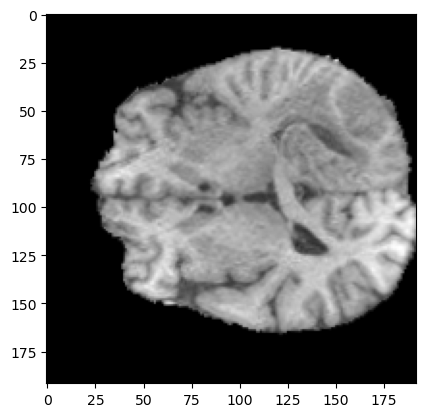

In [5]:
plt.imshow(a[0,0],cmap='gray')

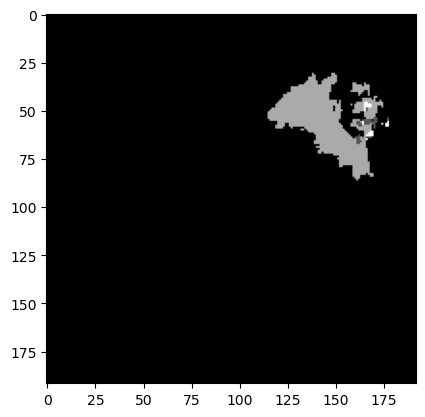

In [6]:
bb = torch.argmax(b,1)
plt.imshow(bb[0],cmap='gray')

# Train Model

In [7]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
!nvidia-smi

Wed Mar 20 09:58:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off | 00000000:84:00.0 Off |                  N/A |
| 29%   31C    P8              22W / 250W |     15MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [8]:
class Squeeze_Excitation(nn.Module):
    def __init__(self, channel, r=8):
        super().__init__()

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.net = nn.Sequential(
            nn.Linear(channel, channel // r, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // r, channel, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, inputs):
        b, c, _, _ = inputs.shape
        x = self.pool(inputs).view(b, c)
        x = self.net(x).view(b, c, 1, 1)
        x = inputs * x
        return x

class Stem_Block(nn.Module):
    def __init__(self, in_c, out_c, stride):
        super().__init__()

        self.c1 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
        )

        self.c2 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=1, stride=stride, padding=0),
            nn.BatchNorm2d(out_c),
        )

        self.attn = Squeeze_Excitation(out_c)

    def forward(self, inputs):
        x = self.c1(inputs)
        s = self.c2(inputs)
        y = self.attn(x + s)
        return y

class ResNet_Block(nn.Module):
    def __init__(self, in_c, out_c, stride):
        super().__init__()

        self.c1 = nn.Sequential(
            nn.BatchNorm2d(in_c),
            nn.ReLU(),
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, stride=stride),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        )

        self.c2 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=1, stride=stride, padding=0),
            nn.BatchNorm2d(out_c),
        )

        self.attn = Squeeze_Excitation(out_c)

    def forward(self, inputs):
        x = self.c1(inputs)
        s = self.c2(inputs)
        y = self.attn(x + s)
        return y

class ASPP(nn.Module):
    def __init__(self, in_c, out_c, rate=[1, 6, 12, 18]):
        super().__init__()

        self.c1 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, dilation=rate[0], padding=rate[0]),
            nn.BatchNorm2d(out_c)
        )

        self.c2 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, dilation=rate[1], padding=rate[1]),
            nn.BatchNorm2d(out_c)
        )

        self.c3 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, dilation=rate[2], padding=rate[2]),
            nn.BatchNorm2d(out_c)
        )

        self.c4 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, dilation=rate[3], padding=rate[3]),
            nn.BatchNorm2d(out_c)
        )

        self.c5 = nn.Conv2d(out_c, out_c, kernel_size=1, padding=0)


    def forward(self, inputs):
        x1 = self.c1(inputs)
        x2 = self.c2(inputs)
        x3 = self.c3(inputs)
        x4 = self.c4(inputs)
        x = x1 + x2 + x3 + x4
        y = self.c5(x)
        return y

class Attention_Block(nn.Module):
    def __init__(self, in_c):
        super().__init__()
        out_c = in_c[1]

        self.g_conv = nn.Sequential(
            nn.BatchNorm2d(in_c[0]),
            nn.ReLU(),
            nn.Conv2d(in_c[0], out_c, kernel_size=3, padding=1),
            nn.MaxPool2d((2, 2))
        )

        self.x_conv = nn.Sequential(
            nn.BatchNorm2d(in_c[1]),
            nn.ReLU(),
            nn.Conv2d(in_c[1], out_c, kernel_size=3, padding=1),
        )

        self.gc_conv = nn.Sequential(
            nn.BatchNorm2d(in_c[1]),
            nn.ReLU(),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
        )

    def forward(self, g, x):
        g_pool = self.g_conv(g)
        x_conv = self.x_conv(x)
        gc_sum = g_pool + x_conv
        gc_conv = self.gc_conv(gc_sum)
        y = gc_conv * x
        return y

class Decoder_Block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.a1 = Attention_Block(in_c)
        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        self.r1 = ResNet_Block(in_c[0]+in_c[1], out_c, stride=1)

    def forward(self, g, x):
        d = self.a1(g, x)
        d = self.up(d)
        d = torch.cat([d, g], axis=1)
        d = self.r1(d)
        return d

class resunetplusplus(nn.Module):
    def __init__(self):
        super().__init__()

        self.c1 = Stem_Block(4, 16, stride=1)
        self.c2 = ResNet_Block(16, 32, stride=2)
        self.c3 = ResNet_Block(32, 64, stride=2)
        self.c4 = ResNet_Block(64, 128, stride=2)

        self.b1 = ASPP(128, 256)

        self.d1 = Decoder_Block([64, 256], 128)
        self.d2 = Decoder_Block([32, 128], 64)
        self.d3 = Decoder_Block([16, 64], 32)

        self.aspp = ASPP(32, 16)
        self.output = nn.Conv2d(16, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        c1 = self.c1(inputs)
        c2 = self.c2(c1)
        c3 = self.c3(c2)
        c4 = self.c4(c3)

        b1 = self.b1(c4)

        d1 = self.d1(c3, b1)
        d2 = self.d2(c2, d1)
        d3 = self.d3(c1, d2)

        output = self.aspp(d3)
        output = self.output(output)

        return output

In [9]:
class DiceLoss(nn.Module):
    def __init__(self, eps: float = 1e-9):
        super(DiceLoss, self).__init__()
        self.eps = eps

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        num = targets.size(0)
        probability = torch.sigmoid(logits)
        probability = probability.contiguous().view(num, -1)
        targets = targets.contiguous().view(num, -1)

        assert probability.shape == targets.shape, "Probability and target shapes do not match"

        intersection = 2.0 * (probability * targets).sum()
        union = probability.sum() + targets.sum()
        dice_score = (intersection + self.eps) / (union + self.eps)

        return 1.0 - dice_score
    
class BCEDiceLoss(nn.Module):
    """Compute objective loss: BCE loss + DICE loss."""
    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        
    def forward(self, 
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        
        # logits are the images 
        # target are the masks 
        assert(logits.shape == targets.shape)
        dice_loss = self.dice(logits, targets)
        bce_loss = self.bce(logits, targets.float())
        
        # binary cross entropy loss & dice loss 
        return bce_loss + dice_loss

In [16]:
# Define the training loop
def train_one_epoch1(model, optimizer, data_loader, device):
    model.train()
    epoch_loss = 0
    bce_dice_loss = BCEDiceLoss().to(device)
    for inputs, targets in data_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = bce_dice_loss(outputs, targets[:, 0:1, :, :])
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"\rBatch Loss: {loss.item():.4f}", end="")
    return epoch_loss / len(data_loader)

# Define the training loop
def train_one_epoch2(model, optimizer, data_loader, device):
    model.train()
    epoch_loss = 0
    bce_dice_loss = BCEDiceLoss().to(device)
    for inputs, targets in data_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = bce_dice_loss(outputs, targets[:, 1:2, :, :])
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"\rBatch Loss: {loss.item():.4f}", end="")
    return epoch_loss / len(data_loader)

# Define the training loop
def train_one_epoch3(model, optimizer, data_loader, device):
    model.train()
    epoch_loss = 0
    bce_dice_loss = BCEDiceLoss().to(device)
    for inputs, targets in data_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = bce_dice_loss(outputs, targets[:, 2:3, :, :])
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"\rBatch Loss: {loss.item():.4f}", end="")
    return epoch_loss / len(data_loader)

# Define the training loop
def train_one_epoch4(model, optimizer, data_loader, device):
    model.train()
    epoch_loss = 0
    bce_dice_loss = BCEDiceLoss().to(device)
    for inputs, targets in data_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = bce_dice_loss(outputs, targets[:, 3:4, :, :])
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"\rBatch Loss: {loss.item():.4f}", end="")
    return epoch_loss / len(data_loader)

# Define the validation loop
def validate1(model, data_loader, device, num_classes):
    model.eval()
    epoch_loss = 0
    bce_dice_loss = BCEDiceLoss().to(device)
    dice_loss = DiceLoss().to(device)
    for inputs, targets in data_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            loss = bce_dice_loss(outputs, targets[:, 0:1, :, :])
            loss_dice = dice_loss(outputs, targets[:, 0:1, :, :])
            epoch_loss += loss.item()
            print(f"\rVal Batch Loss: {loss.item():.4f}", end="")

        d_loss = loss_dice.item()
        dice_score = 1 - d_loss
    return epoch_loss / len(data_loader), dice_score

# Define the validation loop
def validate2(model, data_loader, device, num_classes):
    model.eval()
    epoch_loss = 0
    bce_dice_loss = BCEDiceLoss().to(device)
    dice_loss = DiceLoss().to(device)
    for inputs, targets in data_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            loss = bce_dice_loss(outputs, targets[:, 1:2, :, :])
            loss_dice = dice_loss(outputs, targets[:, 1:2, :, :])
            epoch_loss += loss.item()
            print(f"\rVal Batch Loss: {loss.item():.4f}", end="")

        d_loss = loss_dice.item()
        dice_score = 1 - d_loss
    return epoch_loss / len(data_loader), dice_score

# Define the validation loop
def validate3(model, data_loader, device, num_classes):
    model.eval()
    epoch_loss = 0
    bce_dice_loss = BCEDiceLoss().to(device)
    dice_loss = DiceLoss().to(device)
    for inputs, targets in data_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            loss = bce_dice_loss(outputs, targets[:, 2:3, :, :])
            loss_dice = dice_loss(outputs, targets[:, 2:3, :, :])
            epoch_loss += loss.item()
            print(f"\rVal Batch Loss: {loss.item():.4f}", end="")

        d_loss = loss_dice.item()
        dice_score = 1 - d_loss
    return epoch_loss / len(data_loader), dice_score

# Define the validation loop
def validate4(model, data_loader, device, num_classes):
    model.eval()
    epoch_loss = 0
    bce_dice_loss = BCEDiceLoss().to(device)
    dice_loss = DiceLoss().to(device)
    for inputs, targets in data_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            loss = bce_dice_loss(outputs, targets[:, 3:4, :, :])
            loss_dice = dice_loss(outputs, targets[:, 3:4, :, :])
            epoch_loss += loss.item()
            print(f"\rVal Batch Loss: {loss.item():.4f}", end="")

        d_loss = loss_dice.item()
        dice_score = 1 - d_loss
    return epoch_loss / len(data_loader), dice_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate four models (one for each channel)
model1 = resunetplusplus().to(device)
model2 = resunetplusplus().to(device)
model3 = resunetplusplus().to(device)
model4 = resunetplusplus().to(device)

# Define optimizer (you can adjust this as needed)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.0001)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.0001)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.0001)
optimizer4 = torch.optim.Adam(model4.parameters(), lr=0.0001)

# Initialize statistics for each channel
stats_channel1 = {
    'train_loss': [],
    'valid_loss': [],
    'dice_score': []
}

stats_channel2 = {
    'train_loss': [],
    'valid_loss': [],
    'dice_score': []
}

stats_channel3 = {
    'train_loss': [],
    'valid_loss': [],
    'dice_score': []
}

stats_channel4 = {
    'train_loss': [],
    'valid_loss': [],
    'dice_score': []
}

num_classes = 1

# Training loop
for epoch in range(20):
    print(f'\n --- Epoch {epoch} --- ')
    
    # Training for channel 1
    train_loss1 = train_one_epoch1(model1, optimizer1, train_loader, device)
    valid_loss1, dice_score1 = validate1(model1, valid_loader, device, num_classes)
    stats_channel1['train_loss'].append(train_loss1)
    stats_channel1['valid_loss'].append(valid_loss1)
    stats_channel1['dice_score'].append(dice_score1)

    # Save model statistics and weights for channel 1
    np.save('./resunet++_model_channel1.npy', stats_channel1)
    torch.save(model1.state_dict(), 'resunet_models/model1.pth')

    # Training for channel 2
    train_loss2 = train_one_epoch2(model2, optimizer2, train_loader, device)
    valid_loss2, dice_score2 = validate2(model2, valid_loader, device, num_classes)
    stats_channel2['train_loss'].append(train_loss2)
    stats_channel2['valid_loss'].append(valid_loss2)
    stats_channel2['dice_score'].append(dice_score2)

    # Save model statistics and weights for channel 2
    np.save('./resunet++_model_channel2.npy', stats_channel2)
    torch.save(model2.state_dict(), 'resunet_models/model2.pth')

    # Training for channel 3
    train_loss3 = train_one_epoch3(model3, optimizer3, train_loader, device)
    valid_loss3, dice_score3 = validate3(model3, valid_loader, device, num_classes)
    stats_channel3['train_loss'].append(train_loss3)
    stats_channel3['valid_loss'].append(valid_loss3)
    stats_channel3['dice_score'].append(dice_score3)

    # Save model statistics and weights for channel 3
    np.save('./resunet++_model_channel3.npy', stats_channel3)
    torch.save(model3.state_dict(), 'resunet_models/model3.pth')

    # Training for channel 4
    train_loss4 = train_one_epoch4(model4, optimizer4, train_loader, device)
    valid_loss4, dice_score4 = validate4(model4, valid_loader, device, num_classes)
    stats_channel4['train_loss'].append(train_loss4)
    stats_channel4['valid_loss'].append(valid_loss4)
    stats_channel4['dice_score'].append(dice_score4)

    # Save model statistics and weights for channel 4
    np.save('./resunet++_model_channel4.npy', stats_channel4)
    torch.save(model4.state_dict(), 'resunet_models/model4.pth')


 --- Epoch 0 --- 
Val Batch Loss: 1.4883
 --- Epoch 1 --- 
Val Batch Loss: 1.2606
 --- Epoch 2 --- 
Val Batch Loss: 1.0955
 --- Epoch 3 --- 
Val Batch Loss: 0.7710
 --- Epoch 4 --- 
Val Batch Loss: 0.3456
 --- Epoch 5 --- 
Val Batch Loss: 0.2383
 --- Epoch 6 --- 
Val Batch Loss: 0.1856
 --- Epoch 7 --- 
Val Batch Loss: 0.1427
 --- Epoch 8 --- 
Val Batch Loss: 0.1336
 --- Epoch 9 --- 
Val Batch Loss: 0.1335
 --- Epoch 10 --- 
Val Batch Loss: 0.1188
 --- Epoch 11 --- 
Val Batch Loss: 0.1146
 --- Epoch 12 --- 
Val Batch Loss: 0.1203
 --- Epoch 13 --- 
Val Batch Loss: 0.1946
 --- Epoch 14 --- 
Val Batch Loss: 0.1434
 --- Epoch 15 --- 
Val Batch Loss: 0.1248
 --- Epoch 16 --- 
Val Batch Loss: 0.1244
 --- Epoch 17 --- 
Val Batch Loss: 0.1170
 --- Epoch 18 --- 
Val Batch Loss: 0.1122
 --- Epoch 19 --- 
Val Batch Loss: 0.1093

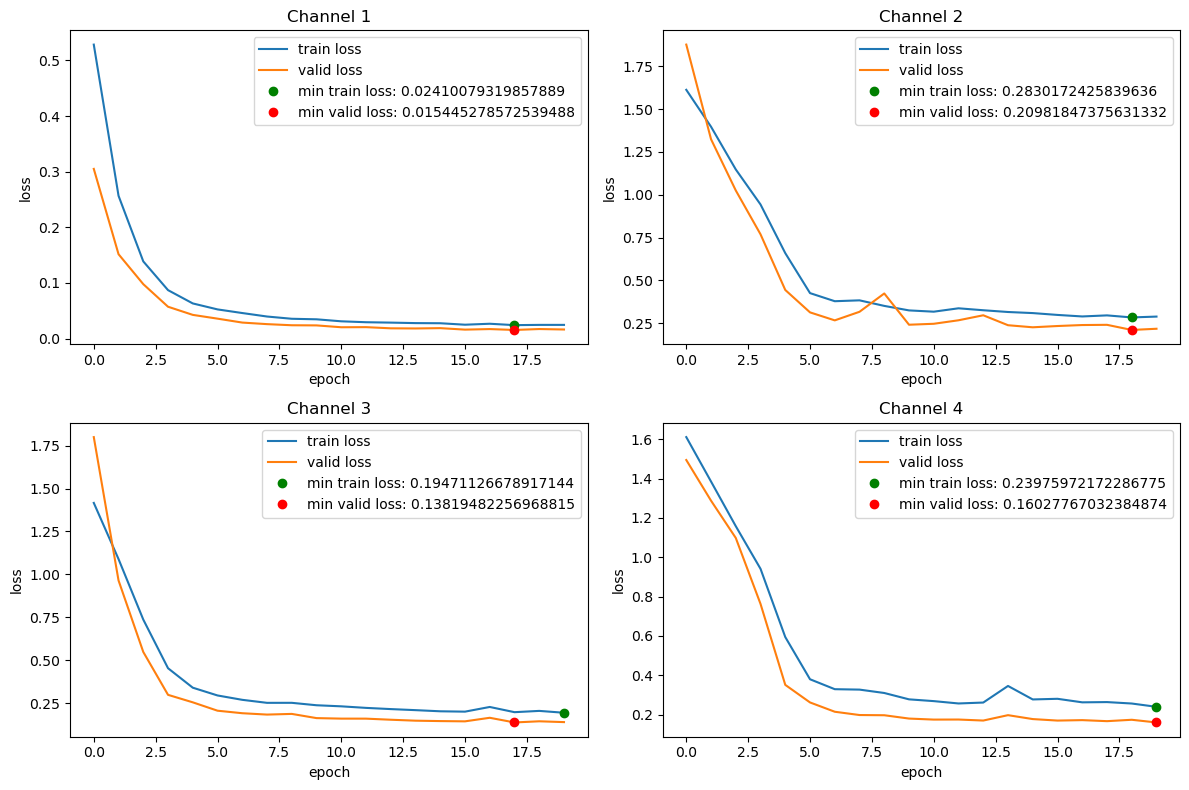

In [2]:
# Load stats for each channel
stats_channel1 = np.load('./resunet++_model_channel1.npy', allow_pickle=True).item()
stats_channel2 = np.load('./resunet++_model_channel2.npy', allow_pickle=True).item()
stats_channel3 = np.load('./resunet++_model_channel3.npy', allow_pickle=True).item()
stats_channel4 = np.load('./resunet++_model_channel4.npy', allow_pickle=True).item()

# Plot for each channel
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

channels = [stats_channel1, stats_channel2, stats_channel3, stats_channel4]
titles = ['Channel 1', 'Channel 2', 'Channel 3', 'Channel 4']

for i, ax in enumerate(axs.flat):
    stats = channels[i]
    train_loss = stats['train_loss']
    valid_loss = stats['valid_loss']
    
    # Find the lowest train and validation loss
    min_train_loss = min(train_loss)
    min_valid_loss = min(valid_loss)

    min_train_loss_epoch = train_loss.index(min_train_loss)
    min_valid_loss_epoch = valid_loss.index(min_valid_loss)
    
    ax.plot(train_loss, label='train loss')
    ax.plot(valid_loss, label='valid loss')
    
    # Display the minimum losses
    ax.plot(min_train_loss_epoch, min_train_loss, 'go', label=f'min train loss: {min_train_loss}')
    ax.plot(min_valid_loss_epoch, min_valid_loss, 'ro', label=f'min valid loss: {min_valid_loss}')
    
    ax.legend(loc='upper right')
    ax.set_title(titles[i])
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')

plt.tight_layout()
plt.show()


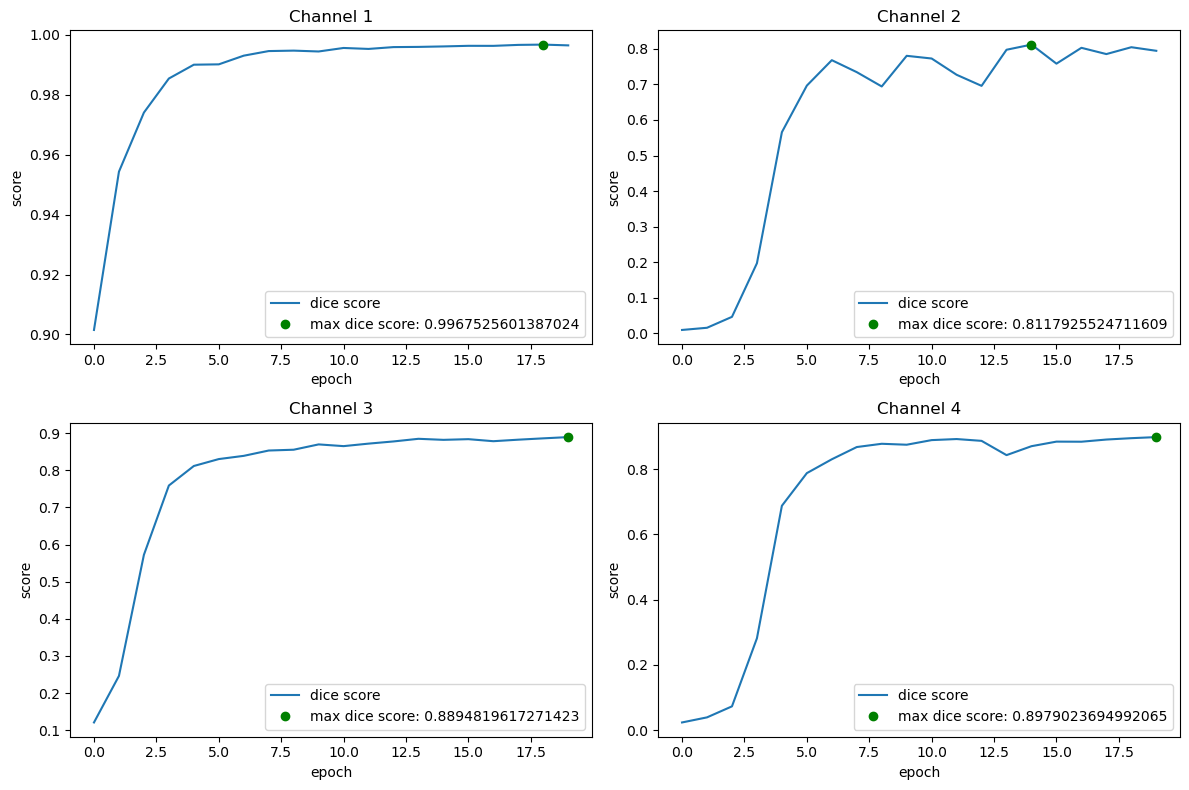

In [3]:
# Load stats for each channel
stats_channel1 = np.load('./resunet++_model_channel1.npy', allow_pickle=True).item()
stats_channel2 = np.load('./resunet++_model_channel2.npy', allow_pickle=True).item()
stats_channel3 = np.load('./resunet++_model_channel3.npy', allow_pickle=True).item()
stats_channel4 = np.load('./resunet++_model_channel4.npy', allow_pickle=True).item()

# Plot for each channel
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

channels = [stats_channel1, stats_channel2, stats_channel3, stats_channel4]
titles = ['Channel 1', 'Channel 2', 'Channel 3', 'Channel 4']

for i, ax in enumerate(axs.flat):
    stats = channels[i]
    dice_score = stats['dice_score']
    
    # Find the highest dice score
    max_dice_score = max(dice_score)
    max_dice_score_epoch = dice_score.index(max_dice_score)
    
    ax.plot(dice_score, label='dice score')
    
    # Display the maximum dice score
    ax.plot(max_dice_score_epoch, max_dice_score, 'go', label=f'max dice score: {max_dice_score}')
    
    ax.legend(loc='lower right')
    ax.set_title(titles[i])
    ax.set_xlabel('epoch')
    ax.set_ylabel('score')

plt.tight_layout()
plt.show()

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model1 = resunetplusplus()#.to(device)
model2 = resunetplusplus()#.to(device)
model3 = resunetplusplus()#.to(device)
model4 = resunetplusplus()#.to(device)

model1.load_state_dict(torch.load('resunet_models/model1.pth'))
model2.load_state_dict(torch.load('resunet_models/model2.pth'))
model3.load_state_dict(torch.load('resunet_models/model3.pth'))
model4.load_state_dict(torch.load('resunet_models/model4.pth'))

<All keys matched successfully>

In [12]:
# Get the input data
a, b = next(iter(train_loader))

# Move the input tensor to GPU if available
#if torch.cuda.is_available():
#    a = a.cuda()

# Make predictions using different models
outputs_channel1 = model1(a)
outputs_channel2 = model2(a)
outputs_channel3 = model3(a)
outputs_channel4 = model4(a)

# Compute the predicted masks
predicted_mask_channel1 = torch.sigmoid(outputs_channel1)
predicted_mask_channel2 = torch.sigmoid(outputs_channel2)
predicted_mask_channel3 = torch.sigmoid(outputs_channel3)
predicted_mask_channel4 = torch.sigmoid(outputs_channel4)

# Convert the predicted masks to CPU tensors and then to NumPy arrays
predicted_mask_cpu_channel1 = predicted_mask_channel1.detach().numpy()#.cpu().detach().numpy()
predicted_mask_cpu_channel2 = predicted_mask_channel2.detach().numpy()#.cpu().detach().numpy()
predicted_mask_cpu_channel3 = predicted_mask_channel3.detach().numpy()#.cpu().detach().numpy()
predicted_mask_cpu_channel4 = predicted_mask_channel4.detach().numpy()#.cpu().detach().numpy()

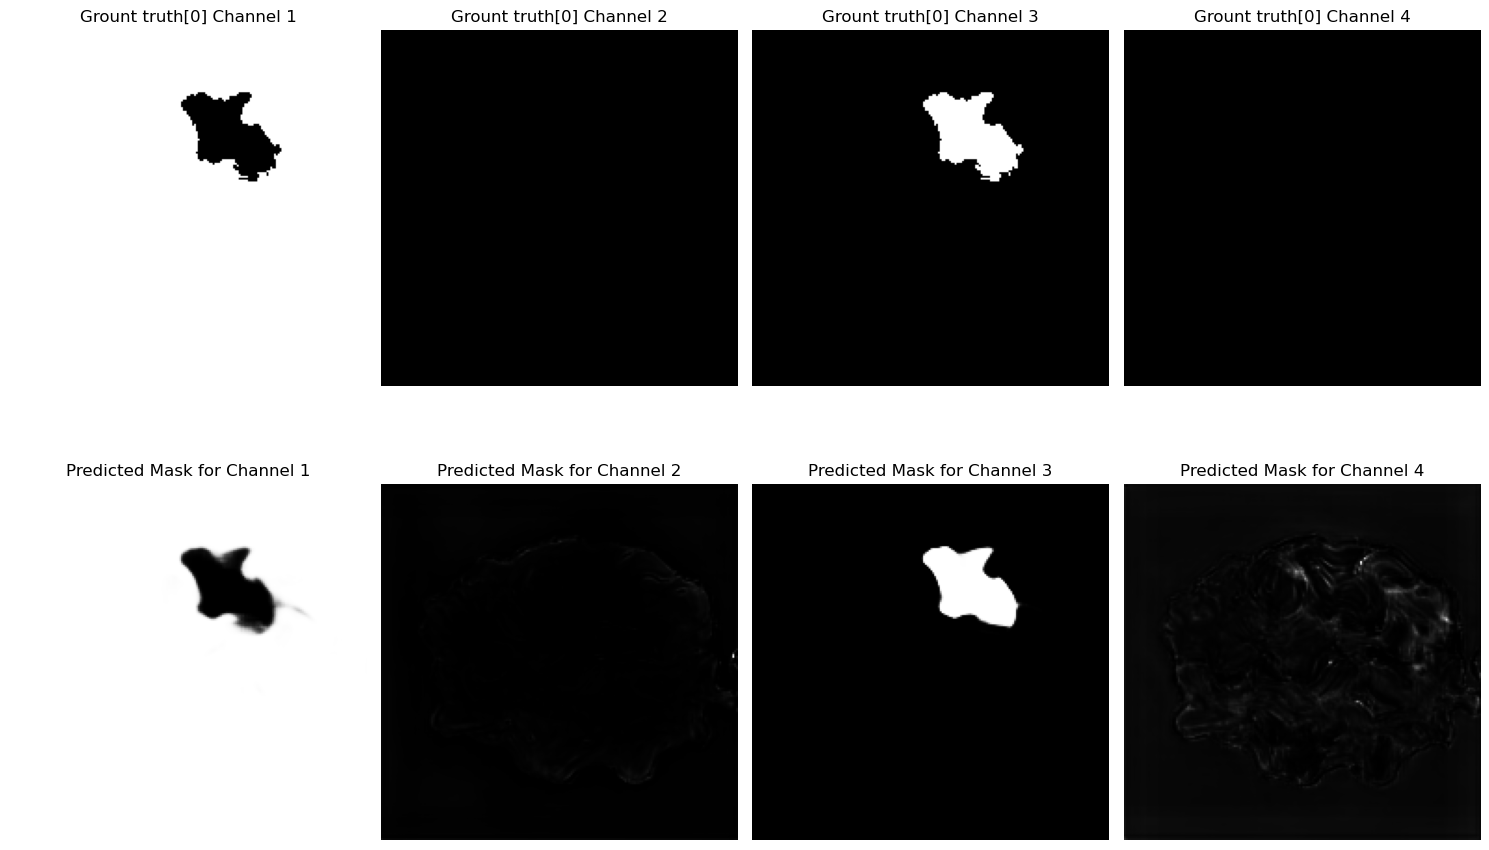

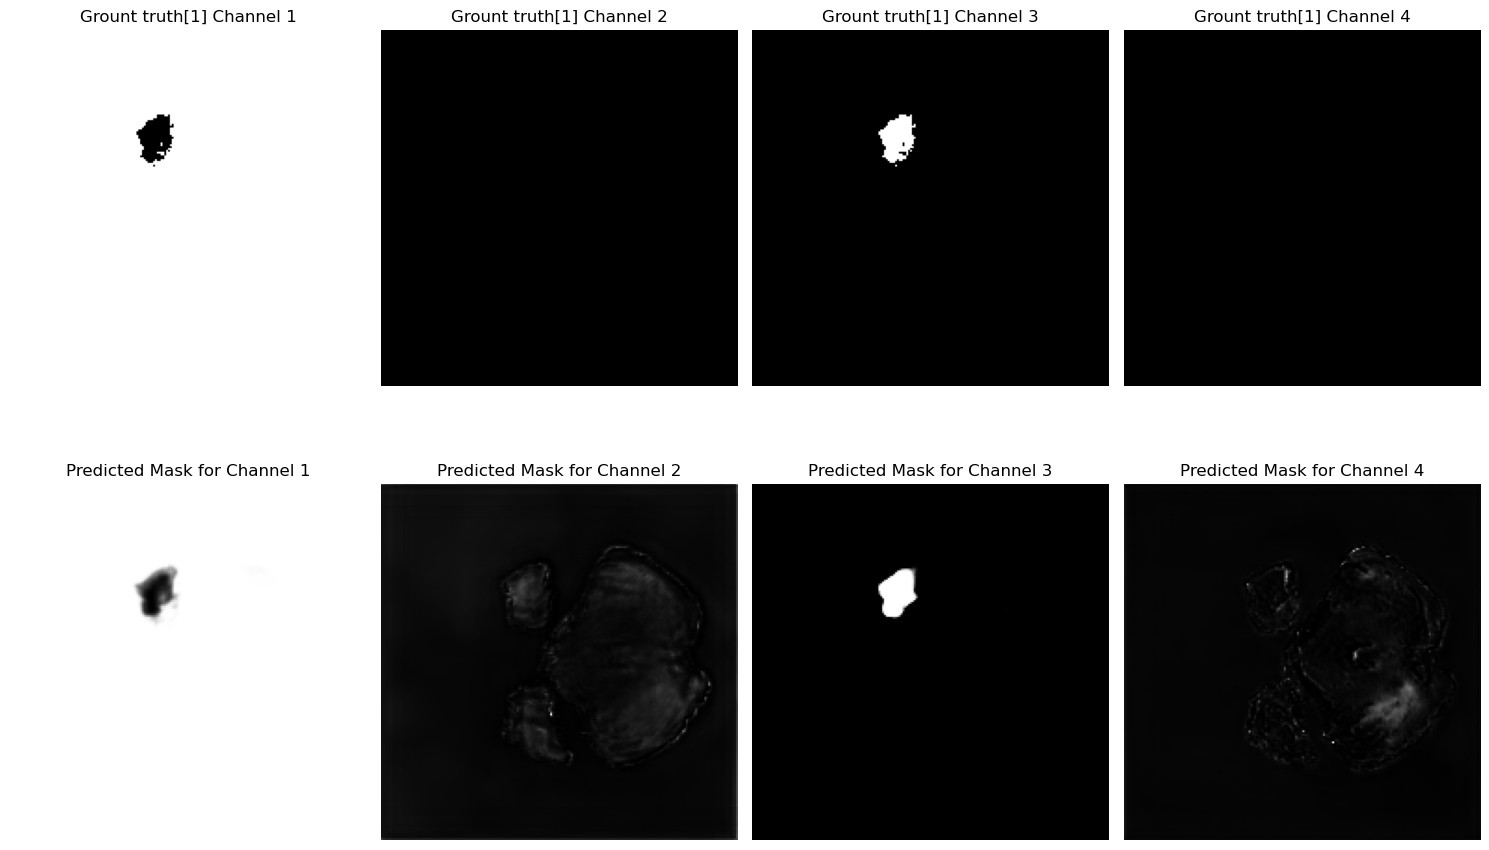

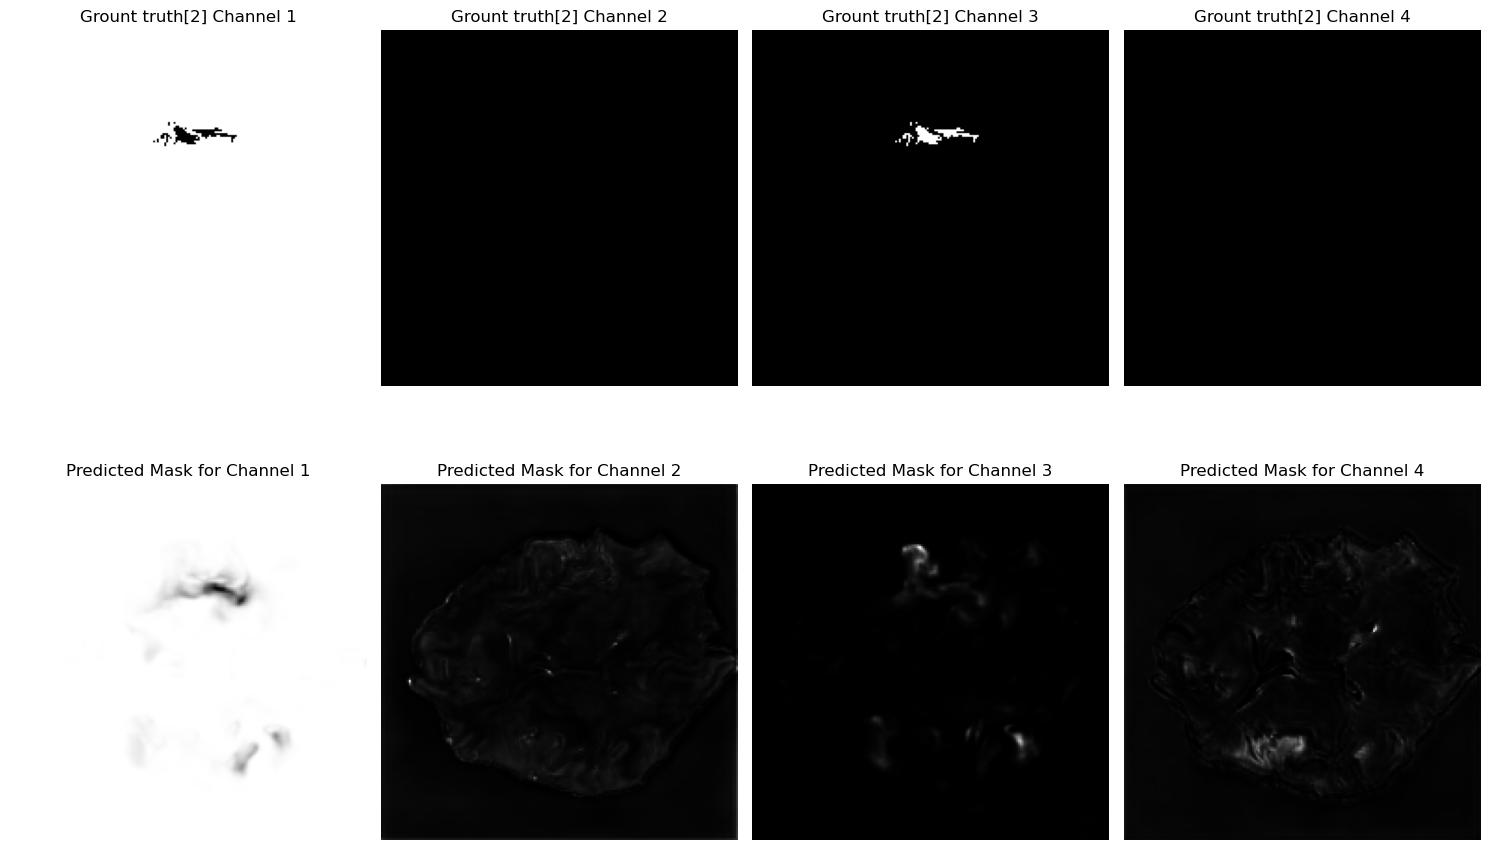

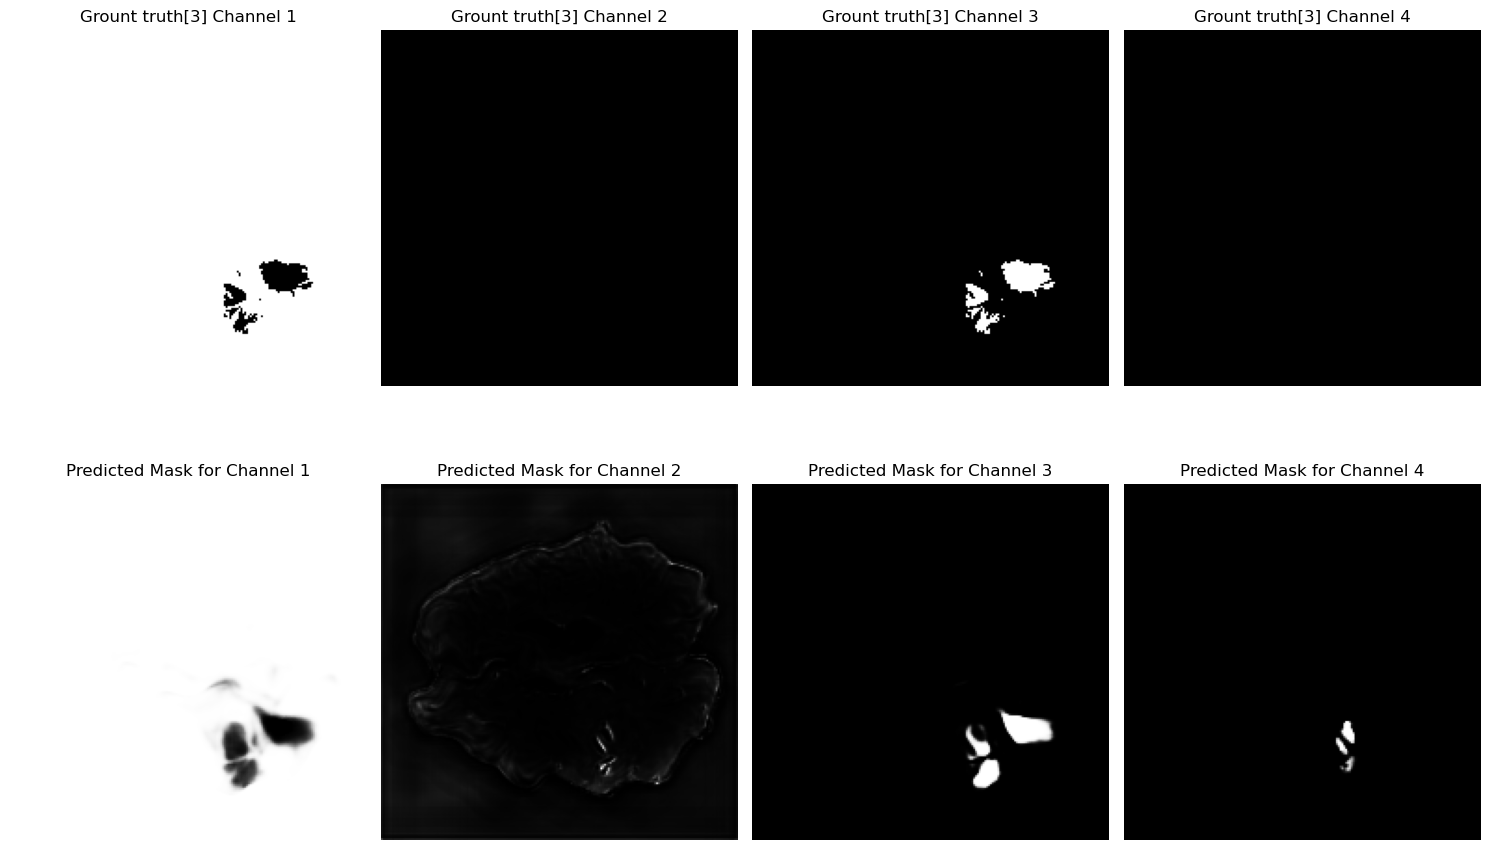

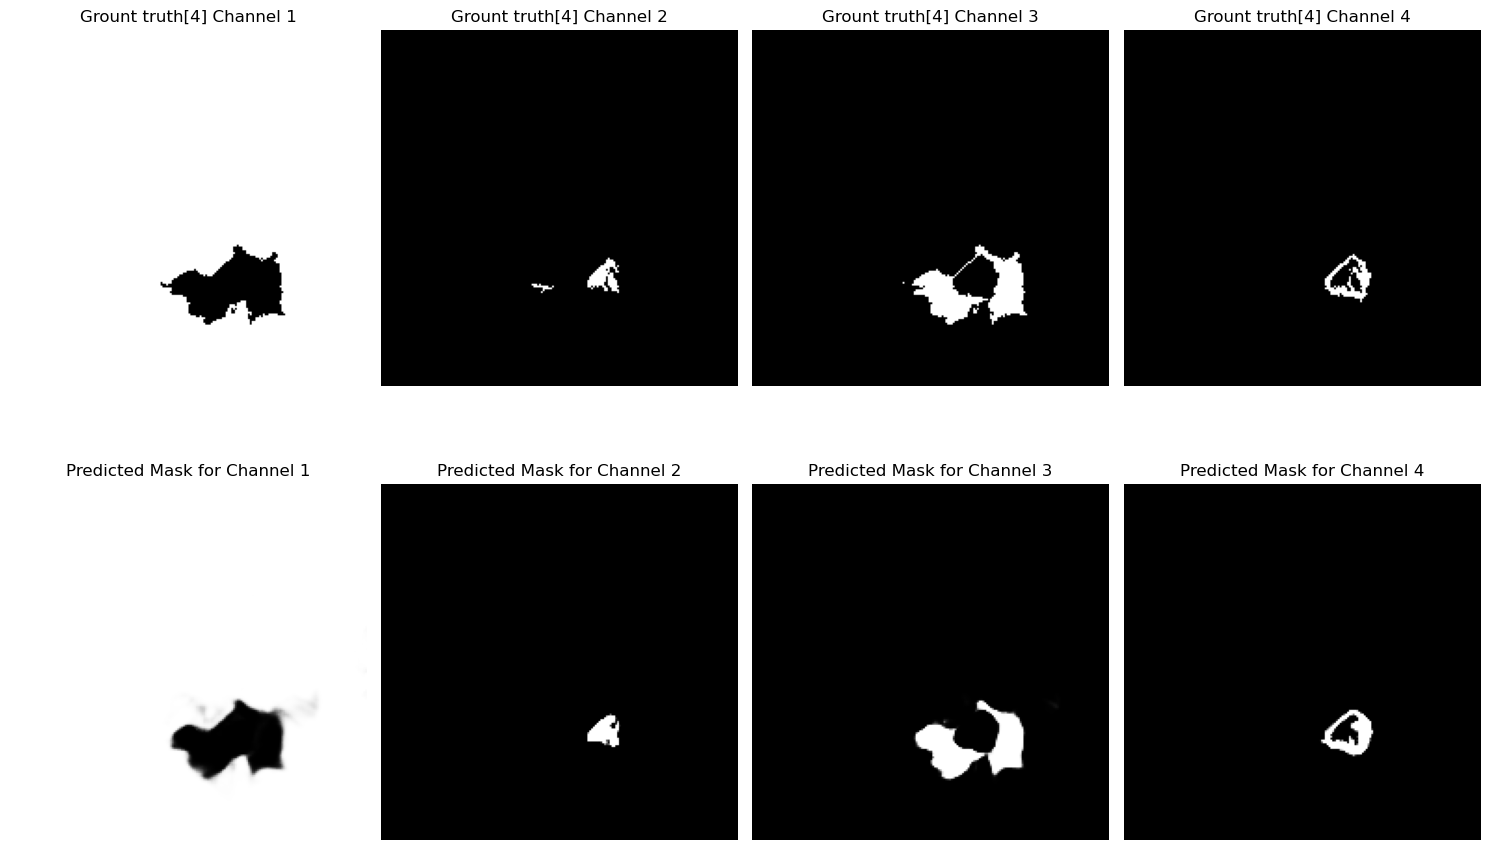

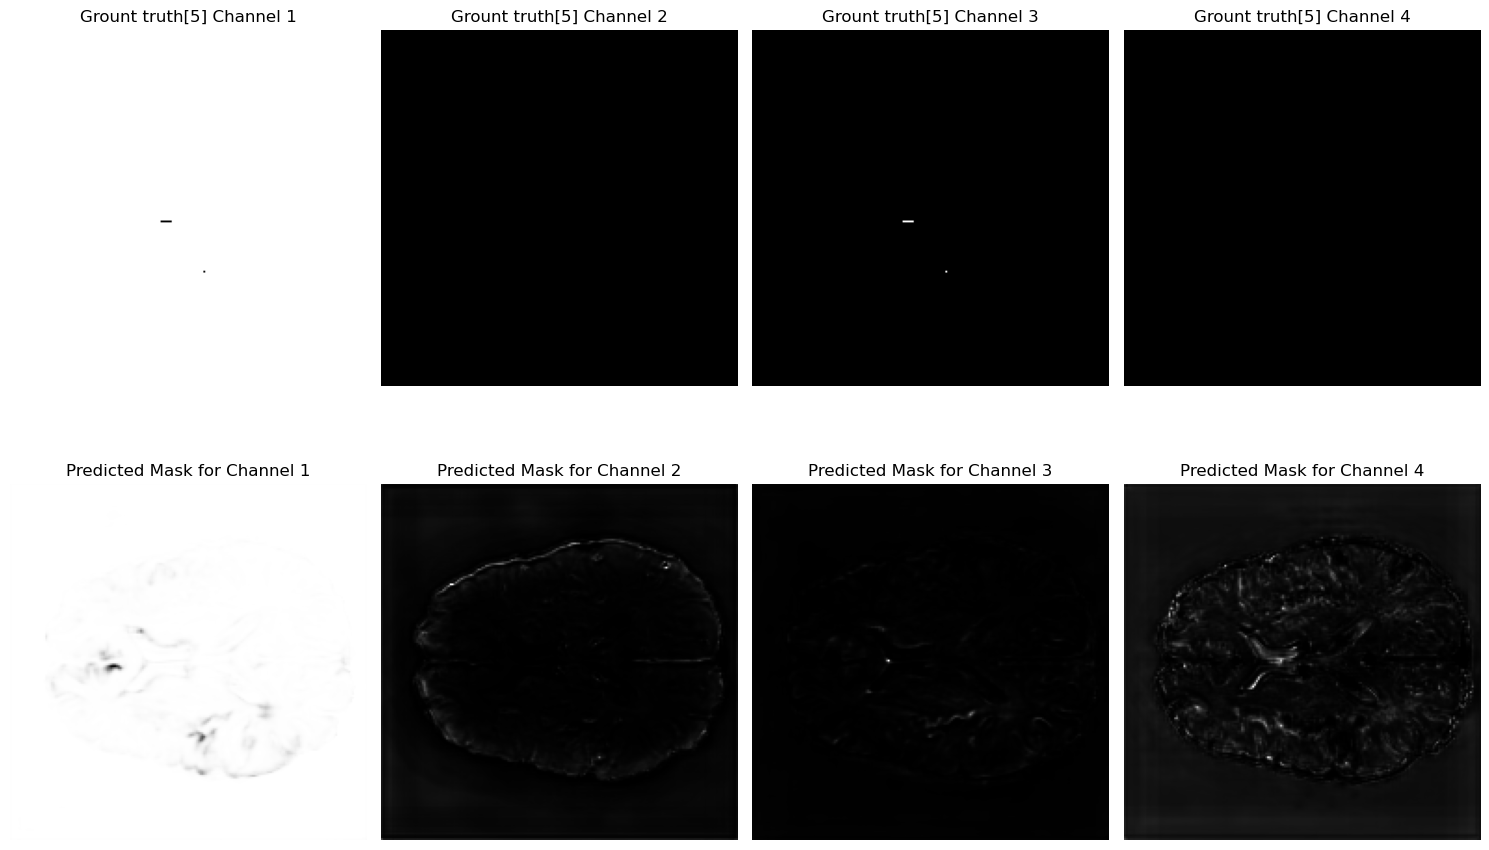

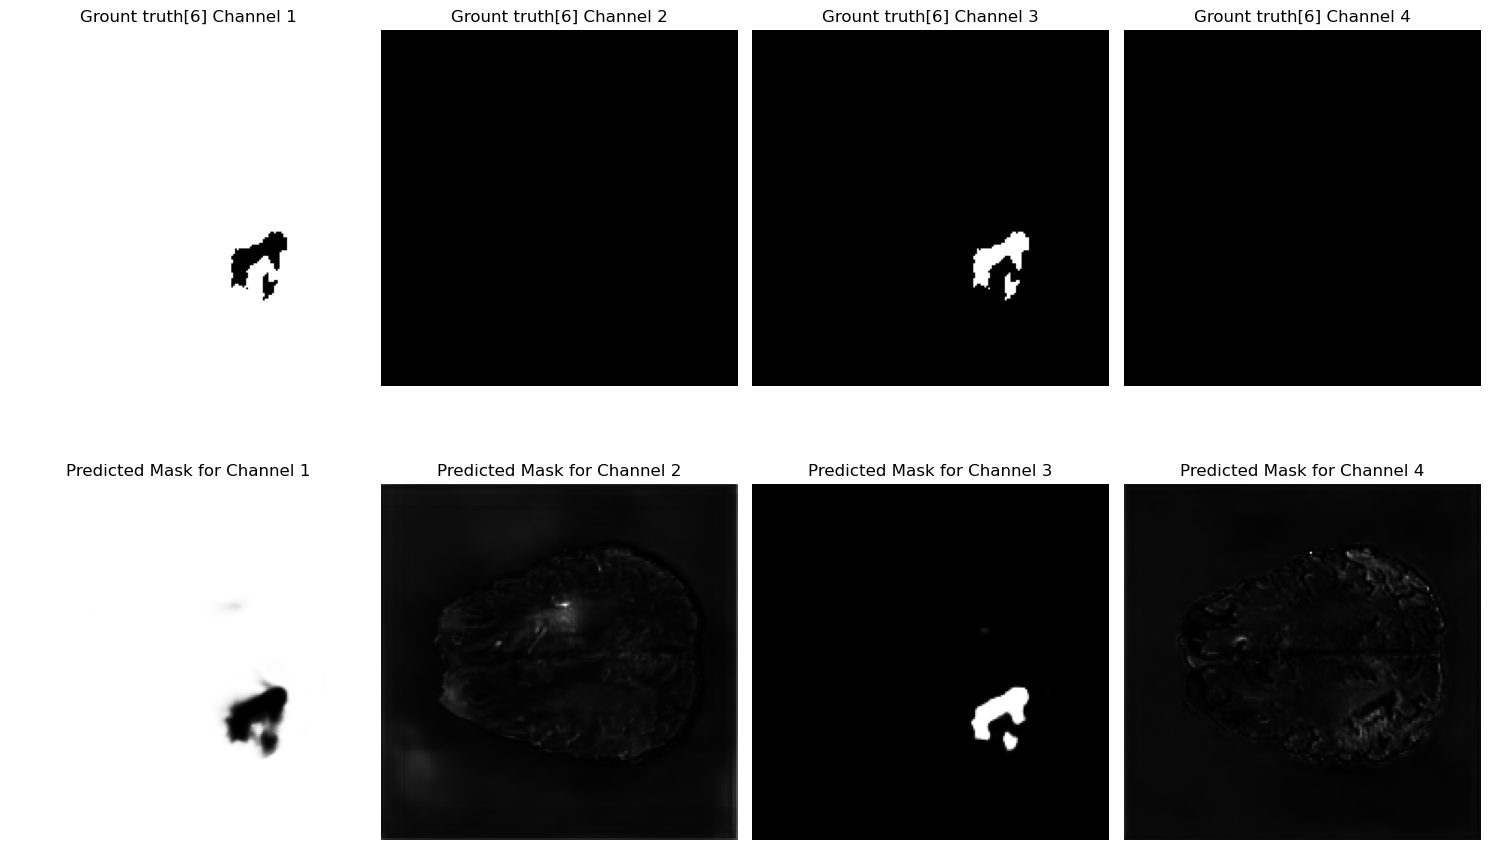

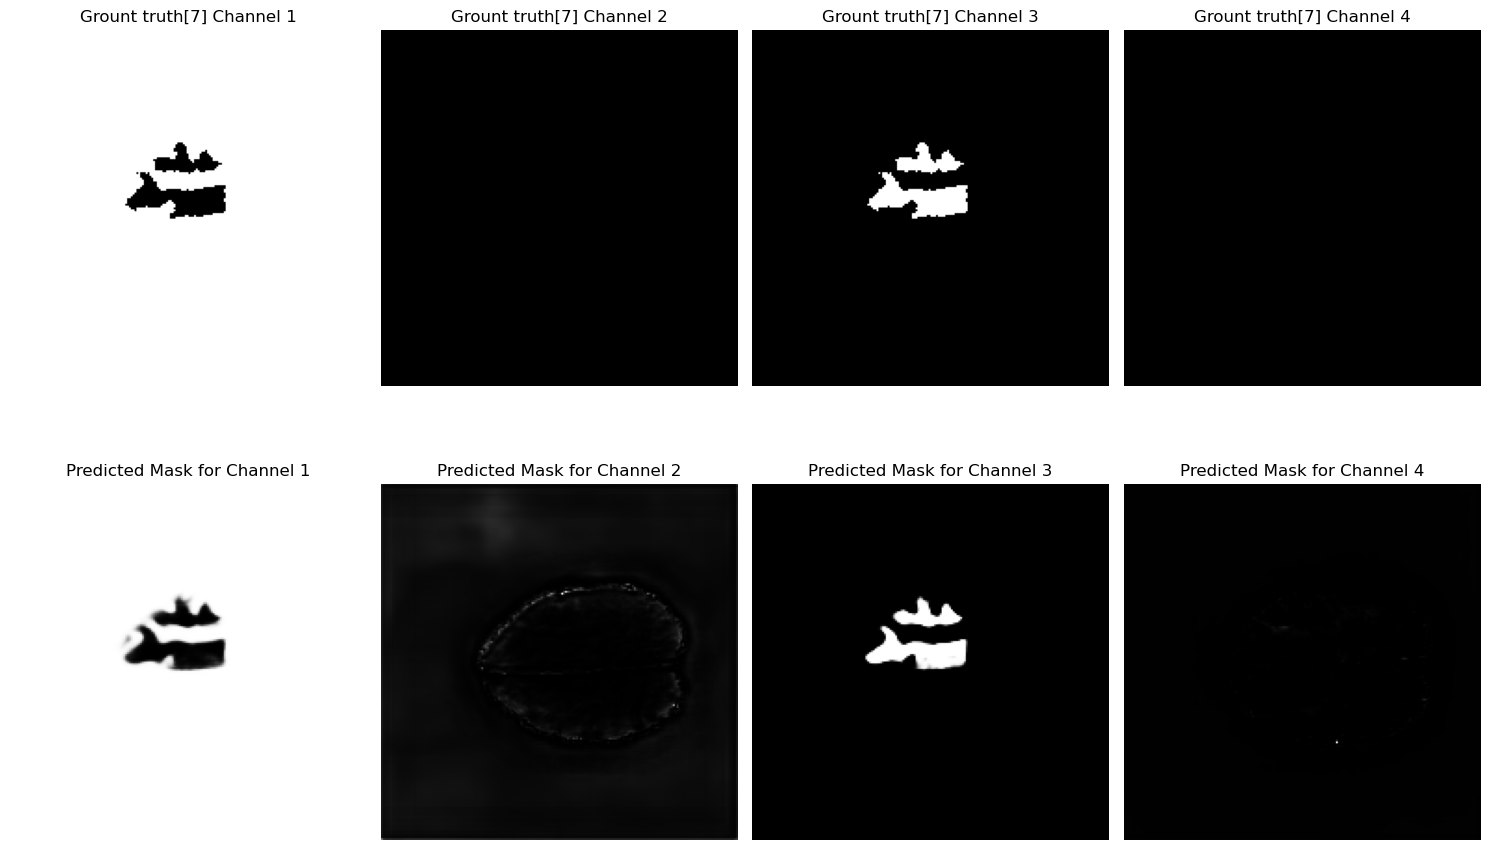

In [21]:
for i in range(0, 8):
    fig, axes = plt.subplots(2, 4, figsize=(15, 10))

    # Plot b[i] on row 1
    for k in range(4):
        axes[0, k].imshow(b[i][k], cmap="gray")
        axes[0, k].set_title(f"Grount truth[{i}] Channel {k+1}")
        axes[0, k].axis('off')

    # Plot predicted_mask_cpu_channel1[i][j] to predicted_mask_cpu_channel4[i][j] on row 2
    for k, prediction in enumerate([predicted_mask_cpu_channel1, predicted_mask_cpu_channel2, predicted_mask_cpu_channel3, predicted_mask_cpu_channel4]):
        axes[1, k].imshow(prediction[i][0], cmap="gray")
        axes[1, k].set_title(f"Predicted Mask for Channel {k+1}")
        axes[1, k].axis('off')


    plt.tight_layout()
    plt.show()


# Test Model

In [22]:
# Get the input data
a, b = next(iter(test_loader))

# Move the input tensor to GPU if available
#if torch.cuda.is_available():
#    a = a.cuda()

# Make predictions using different models
outputs_channel1 = model1(a)
outputs_channel2 = model2(a)
outputs_channel3 = model3(a)
outputs_channel4 = model4(a)

# Compute the predicted masks
predicted_mask_channel1 = torch.sigmoid(outputs_channel1)
predicted_mask_channel2 = torch.sigmoid(outputs_channel2)
predicted_mask_channel3 = torch.sigmoid(outputs_channel3)
predicted_mask_channel4 = torch.sigmoid(outputs_channel4)

# Convert the predicted masks to CPU tensors and then to NumPy arrays
predicted_mask_cpu_channel1 = predicted_mask_channel1.detach().numpy()#.cpu().detach().numpy()
predicted_mask_cpu_channel2 = predicted_mask_channel2.detach().numpy()#.cpu().detach().numpy()
predicted_mask_cpu_channel3 = predicted_mask_channel3.detach().numpy()#.cpu().detach().numpy()
predicted_mask_cpu_channel4 = predicted_mask_channel4.detach().numpy()#.cpu().detach().numpy()

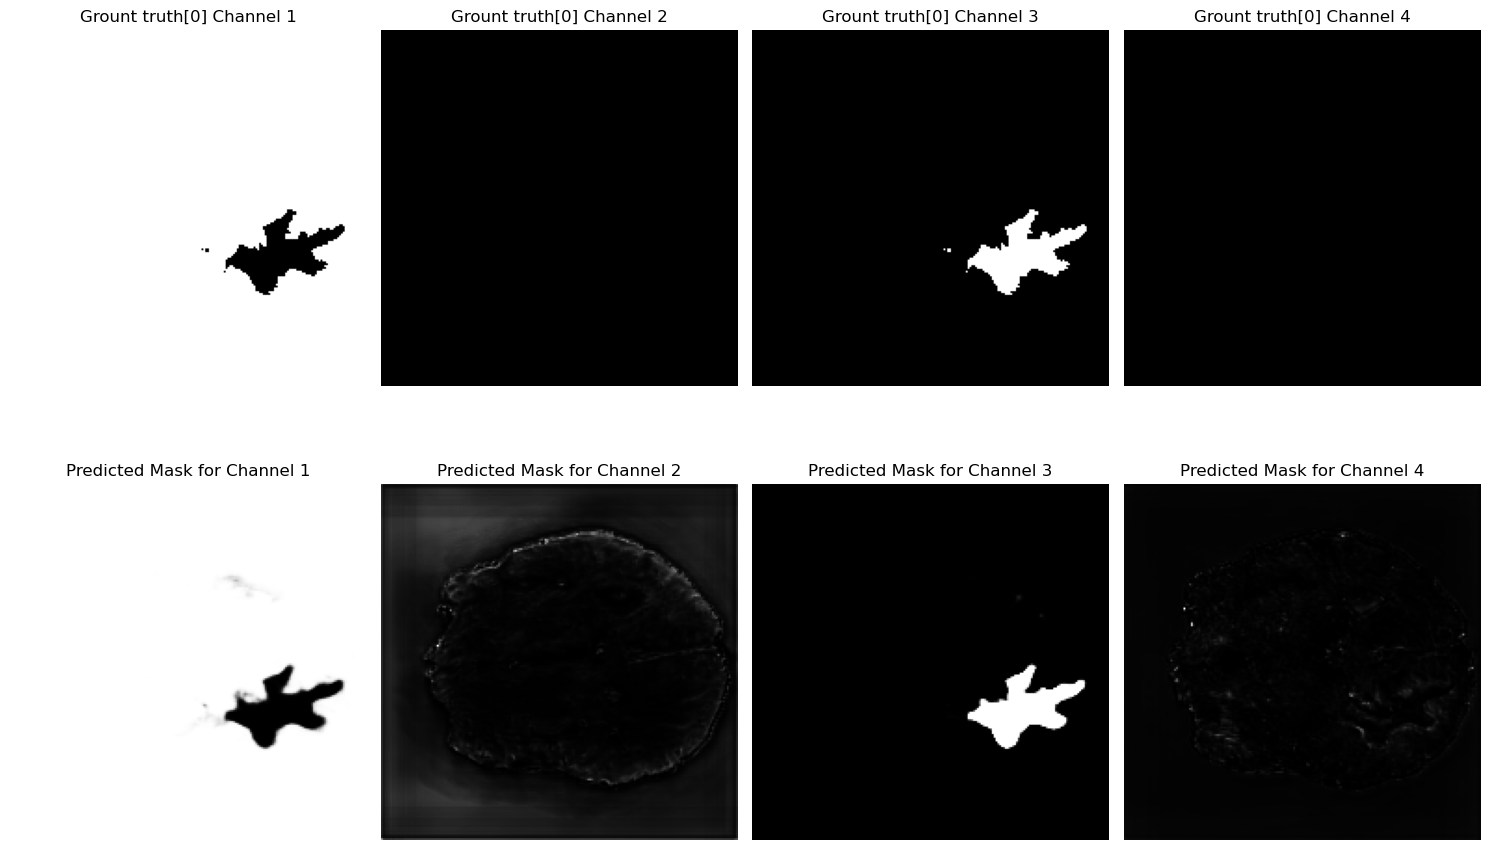

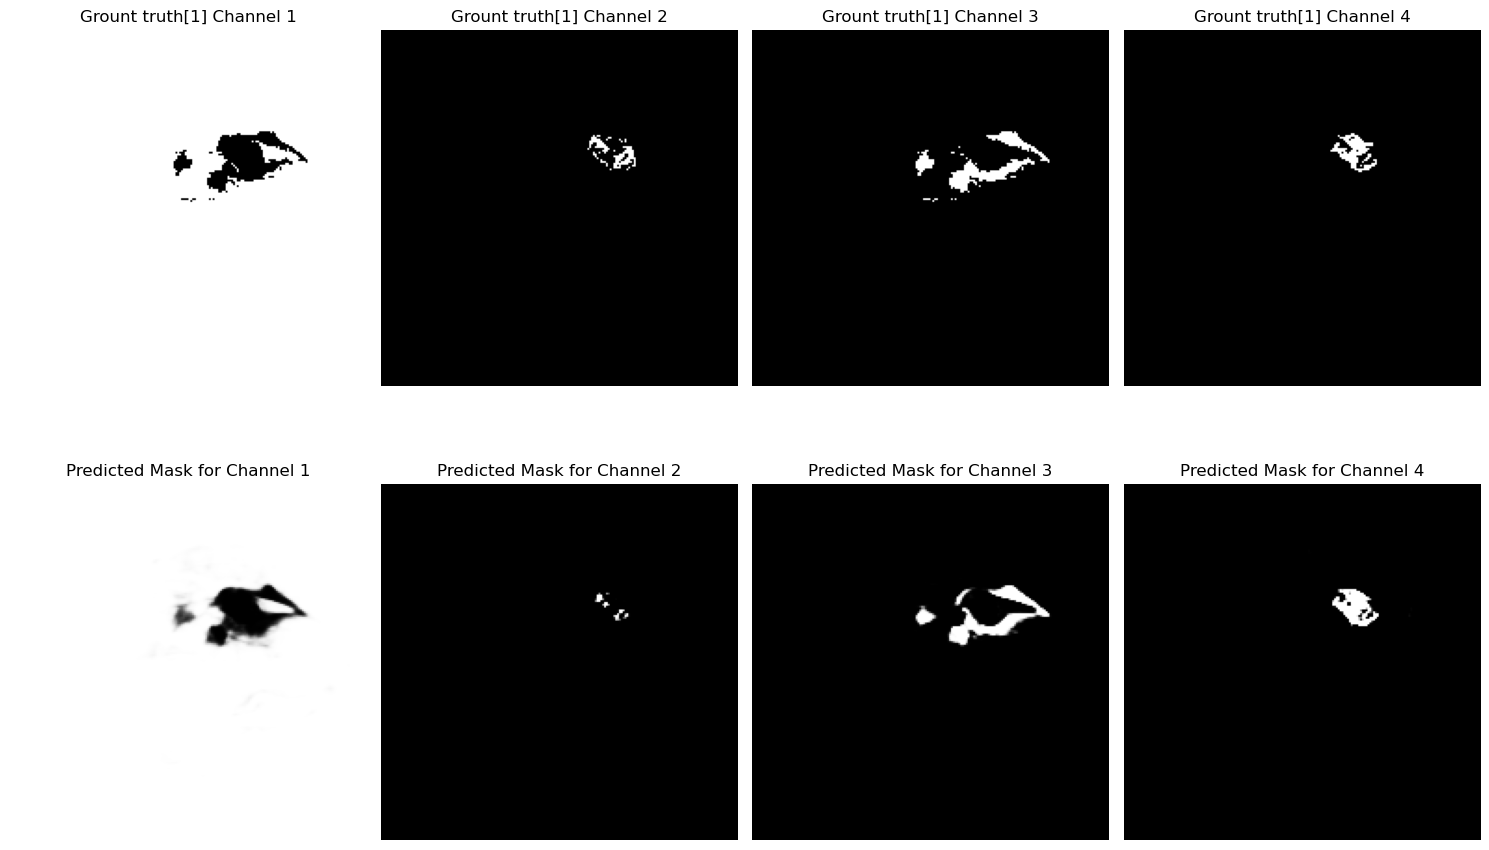

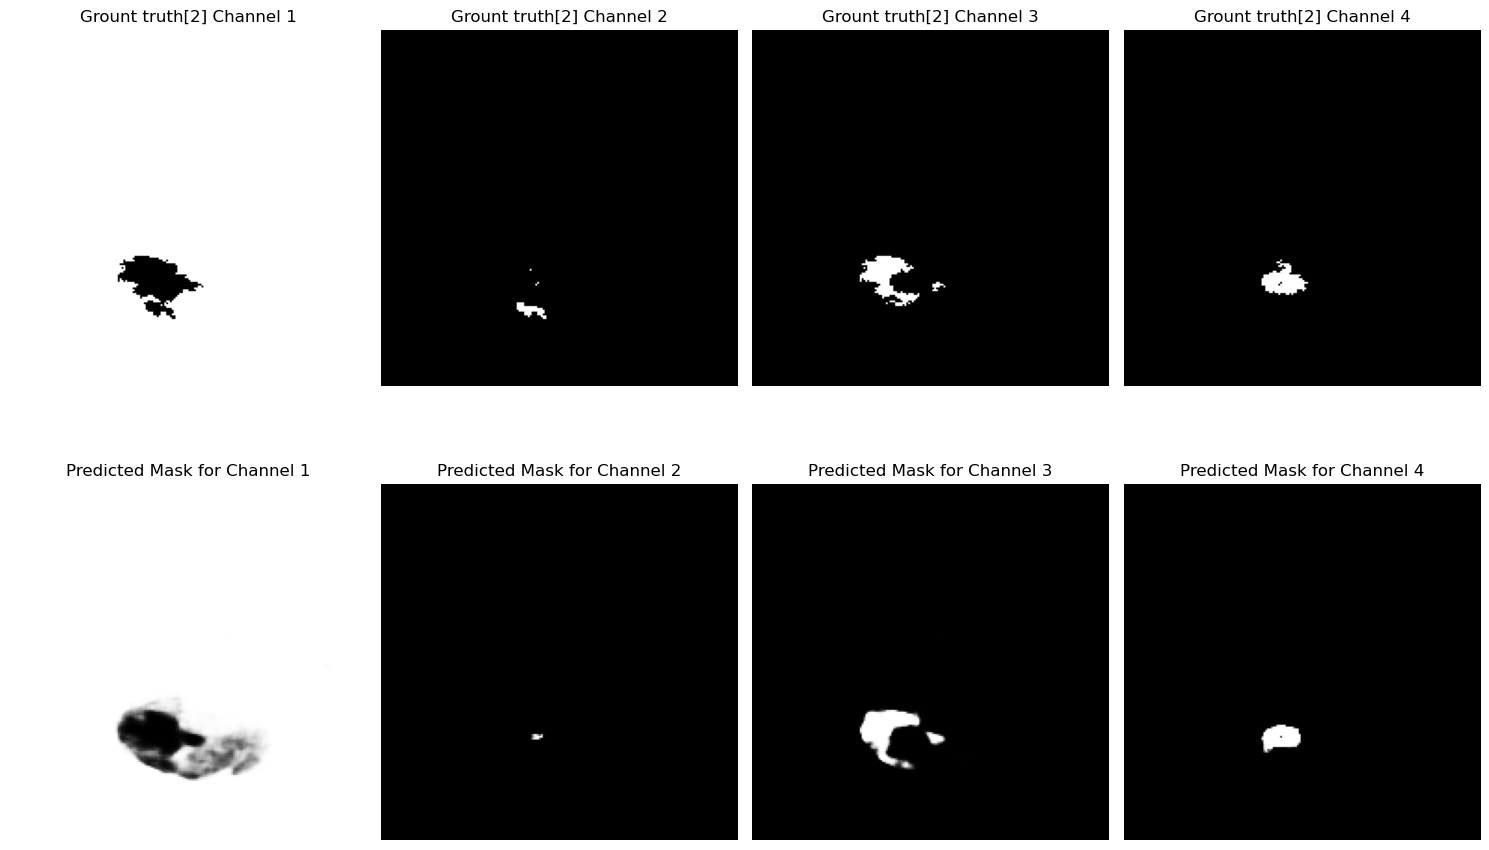

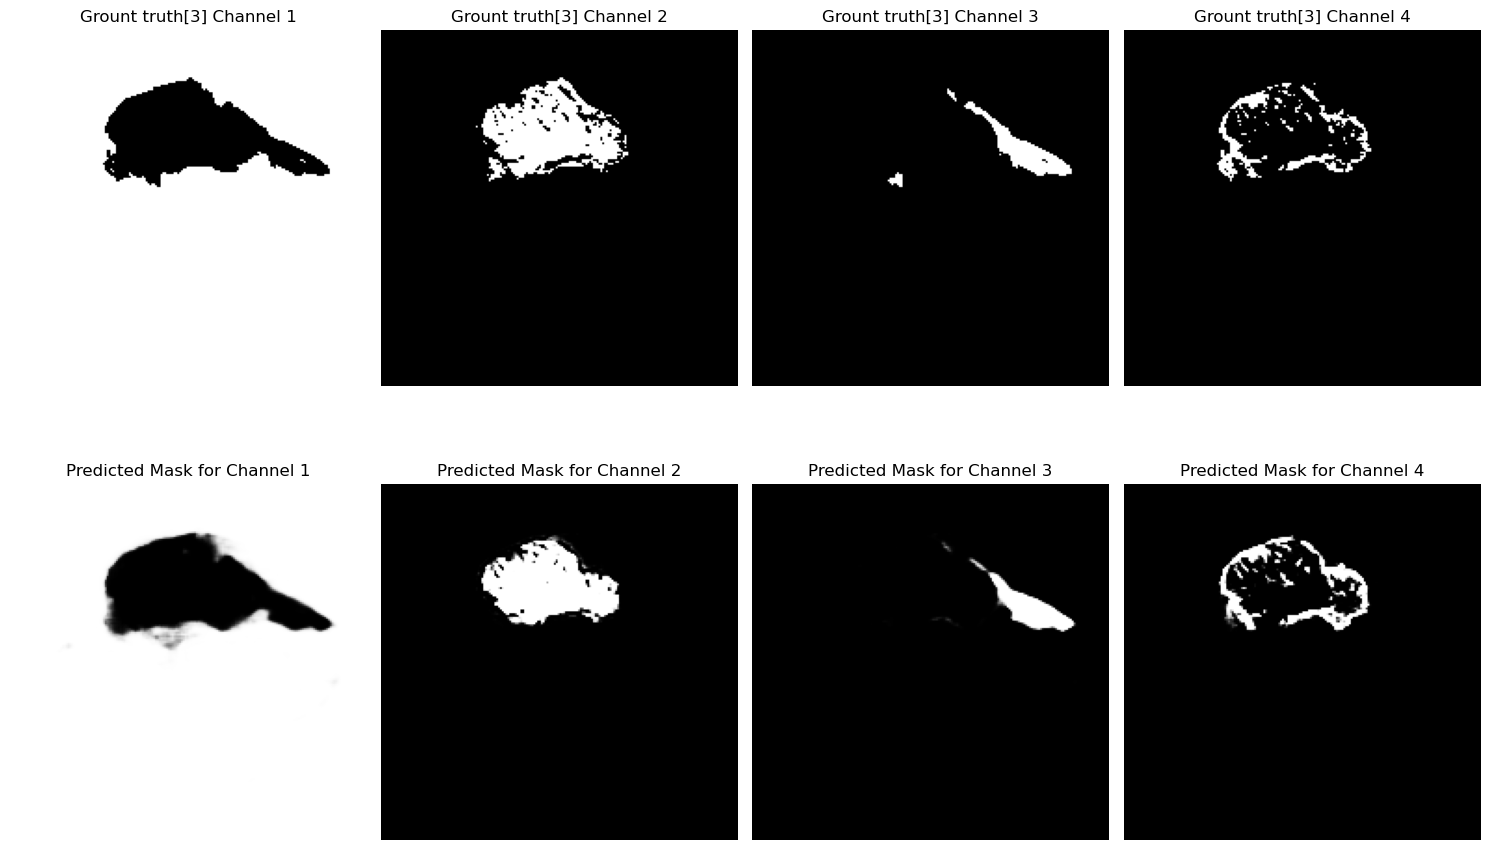

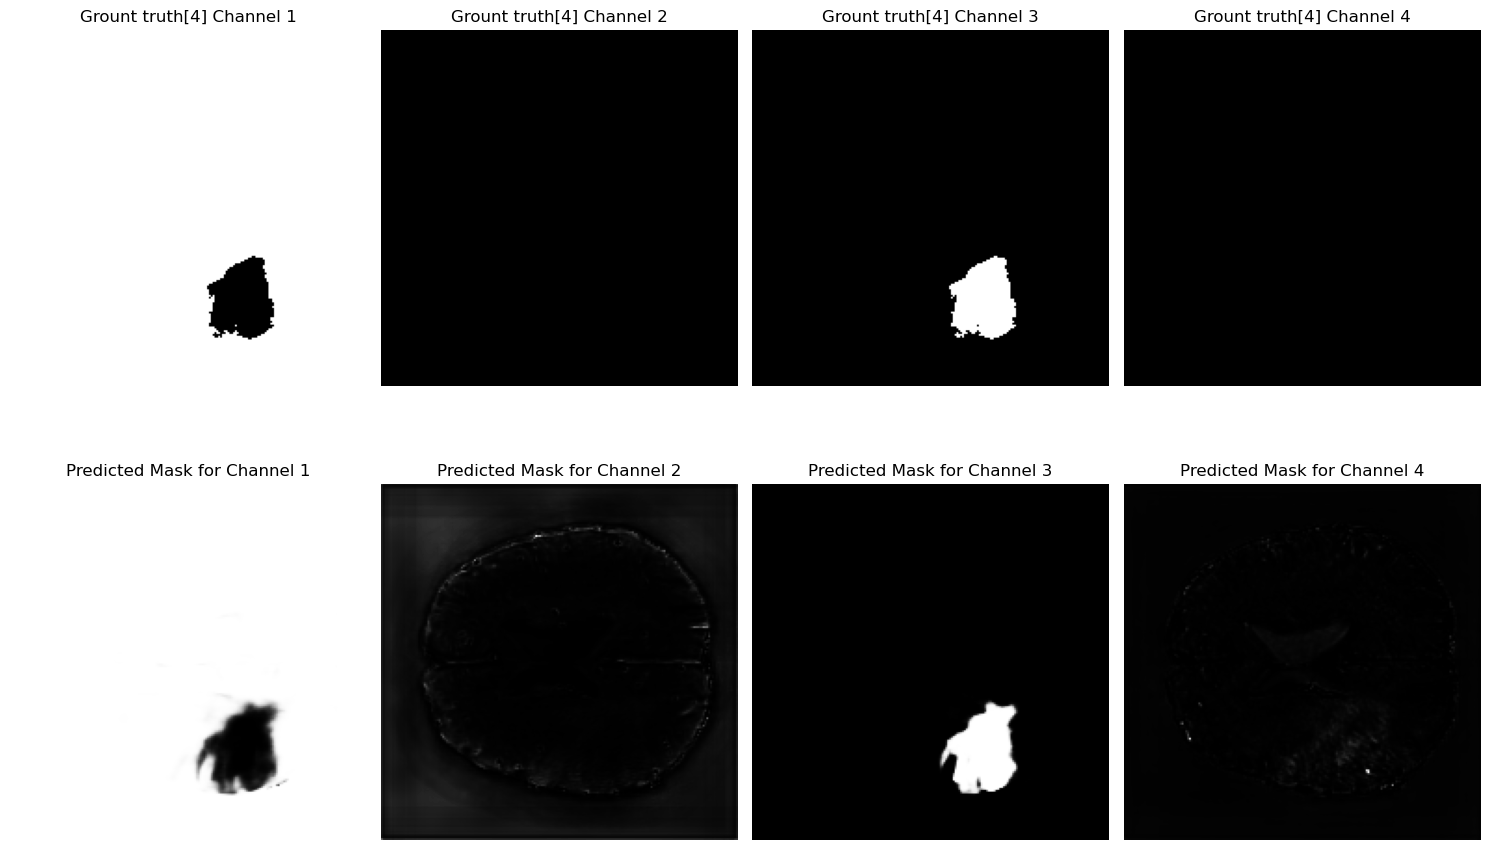

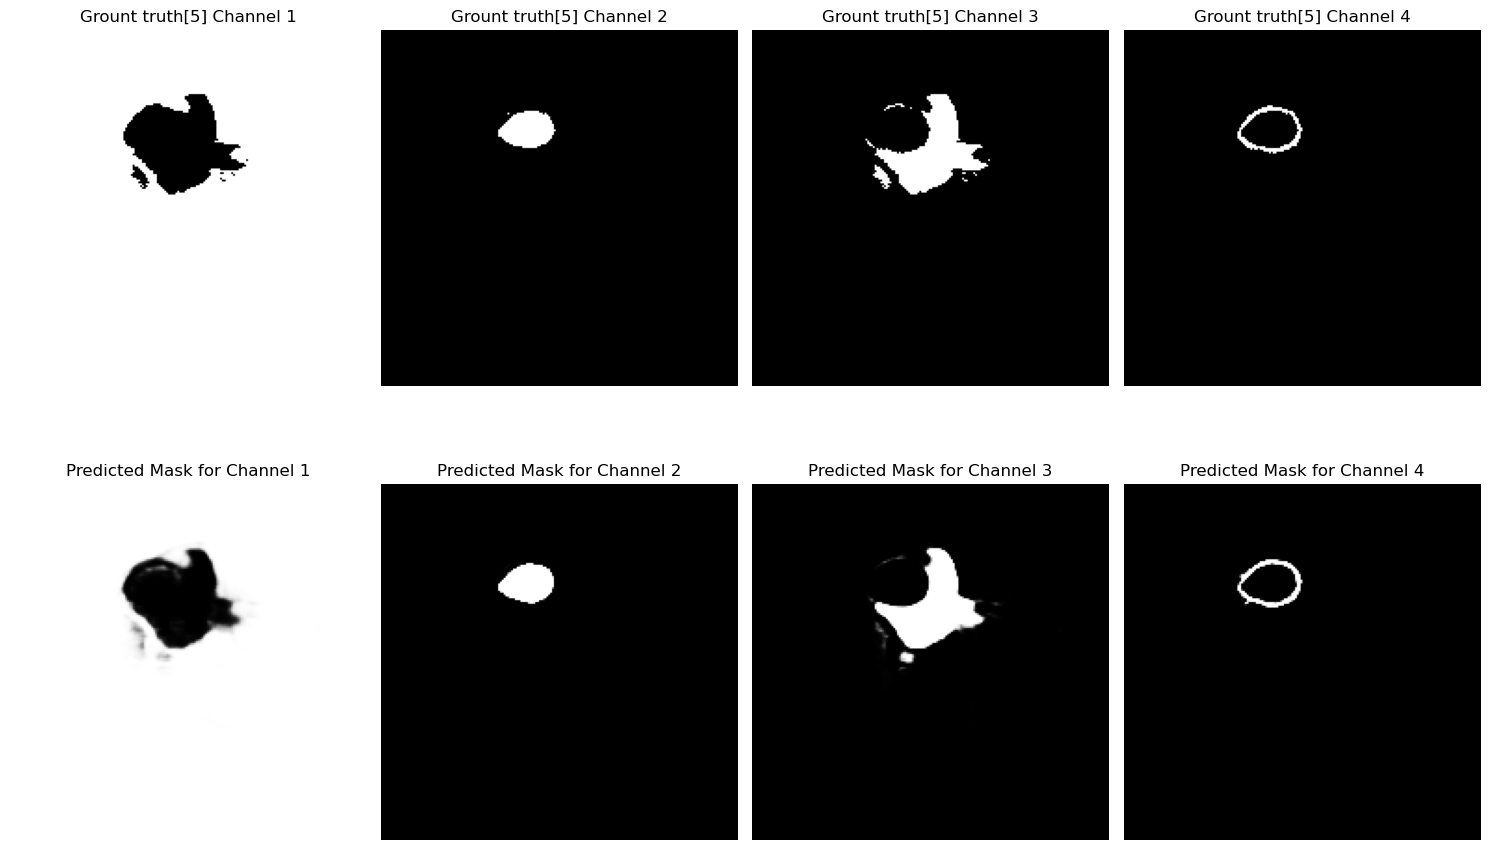

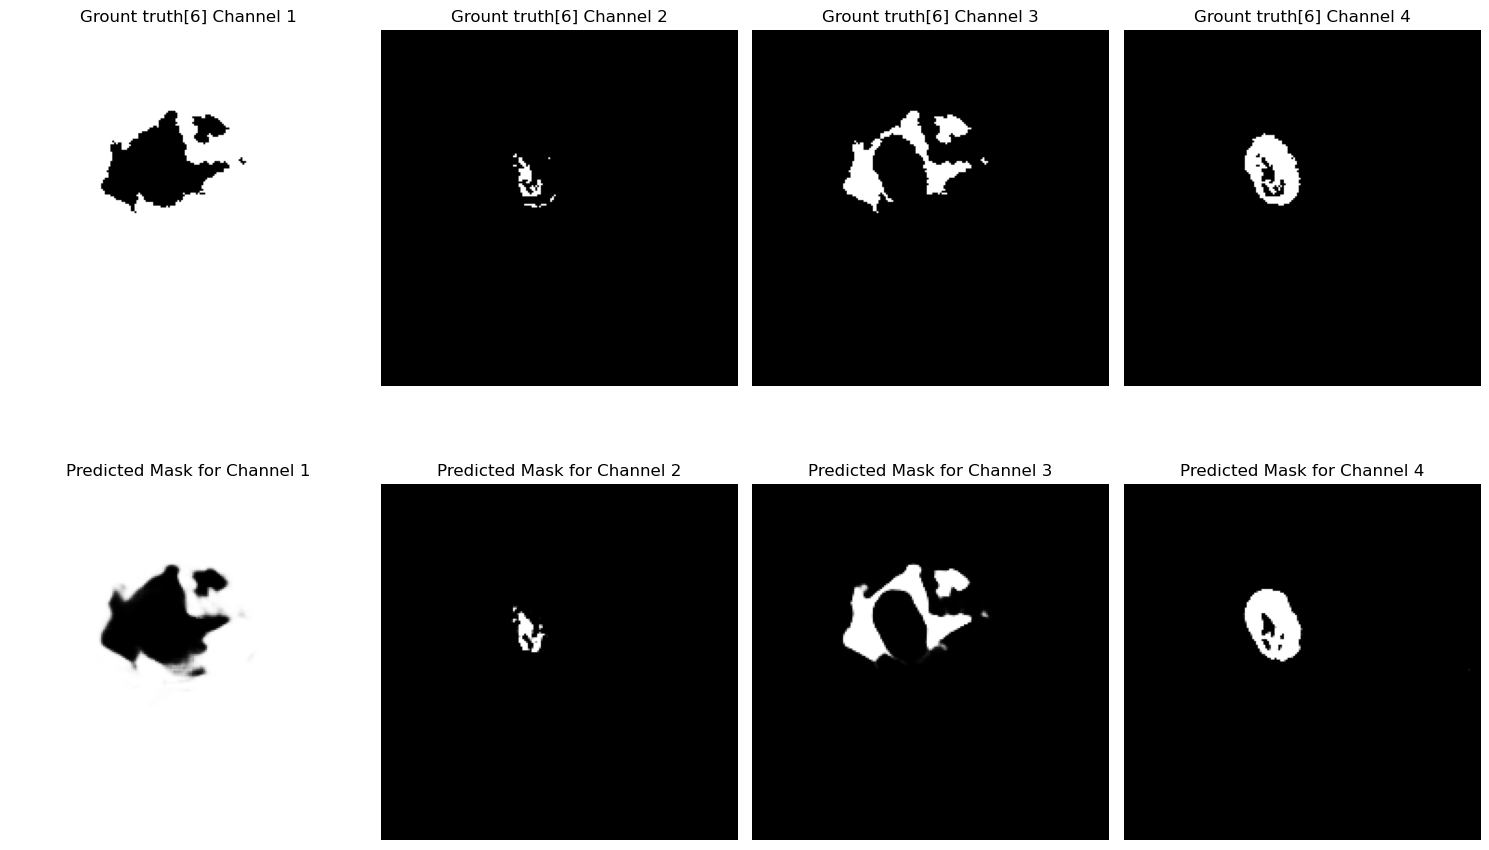

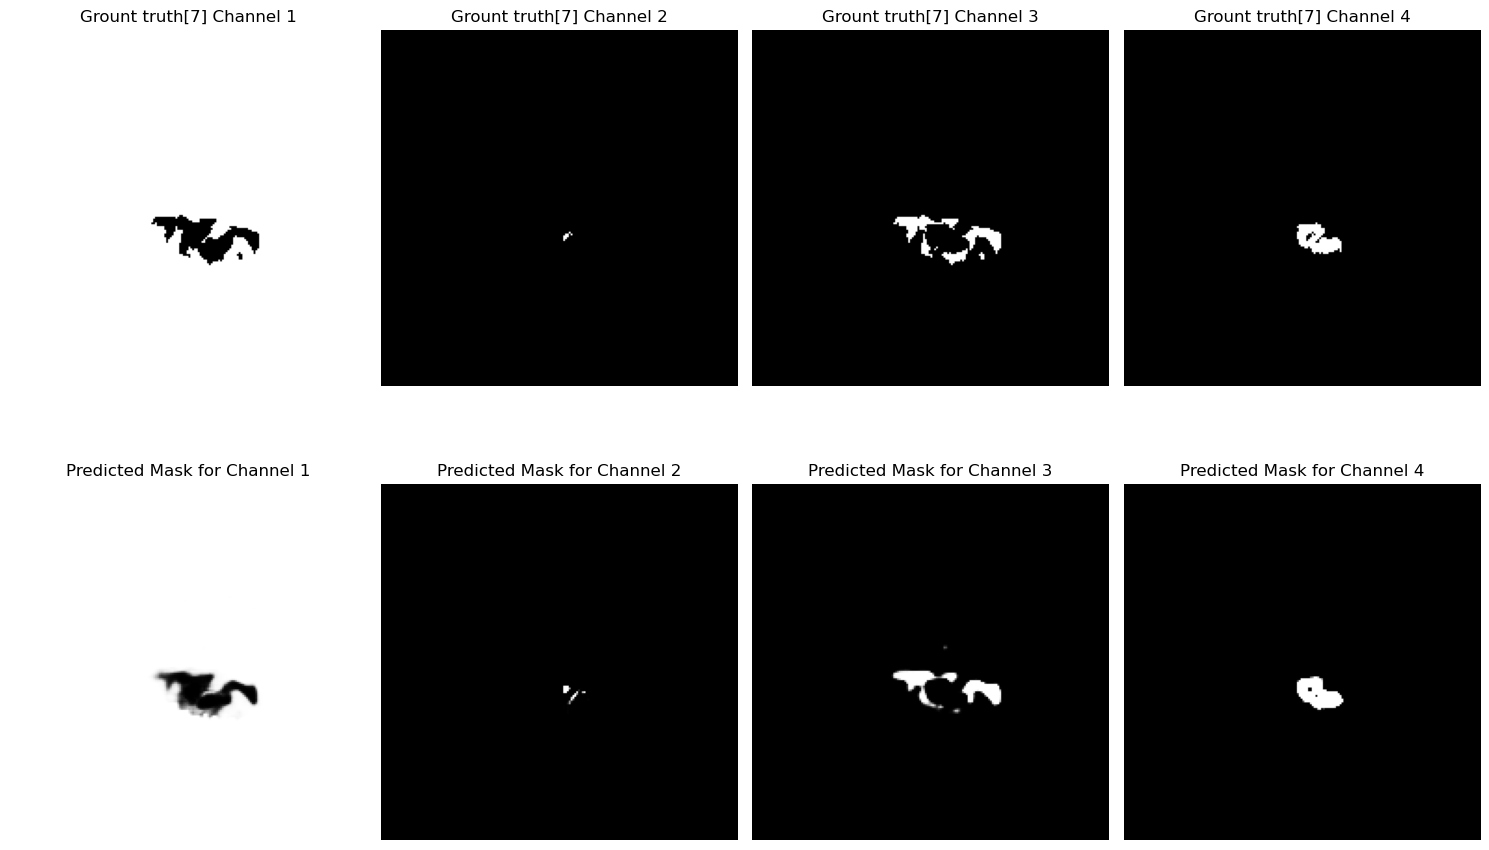

In [23]:
for i in range(0, 8):
    fig, axes = plt.subplots(2, 4, figsize=(15, 10))

    # Plot b[i] on row 1
    for k in range(4):
        axes[0, k].imshow(b[i][k], cmap="gray")
        axes[0, k].set_title(f"Grount truth[{i}] Channel {k+1}")
        axes[0, k].axis('off')

    # Plot predicted_mask_cpu_channel1[i][j] to predicted_mask_cpu_channel4[i][j] on row 2
    for k, prediction in enumerate([predicted_mask_cpu_channel1, predicted_mask_cpu_channel2, predicted_mask_cpu_channel3, predicted_mask_cpu_channel4]):
        axes[1, k].imshow(prediction[i][0], cmap="gray")
        axes[1, k].set_title(f"Predicted Mask for Channel {k+1}")
        axes[1, k].axis('off')


    plt.tight_layout()
    plt.show()


In [28]:
def jaccard_coef_metric(probabilities, truth, treshold = 0.5, eps = 1e-9):

    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = (prediction * truth_).sum()
        union = (prediction.sum() + truth_.sum()) - intersection + eps
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)


model1.eval()
model2.eval()
model3.eval()
model4.eval()

with torch.no_grad():
    total_iou_score_channel1 = 0
    total_iou_score_channel2 = 0
    total_iou_score_channel3 = 0
    total_iou_score_channel4 = 0
    num_samples = 0
    
    for inputs, targets in test_loader:
        inputs = inputs
        targets = targets

        outputs_channel1 = model1(inputs)
        outputs_channel2 = model2(inputs)
        outputs_channel3 = model3(inputs)
        outputs_channel4 = model4(inputs)

        # Compute the predicted masks
        predicted_mask_channel1 = torch.sigmoid(outputs_channel1)
        predicted_mask_channel2 = torch.sigmoid(outputs_channel2)
        predicted_mask_channel3 = torch.sigmoid(outputs_channel3)
        predicted_mask_channel4 = torch.sigmoid(outputs_channel4)

        predicted_mask_cpu_channel1 = outputs_channel1.detach().numpy()
        predicted_mask_cpu_channel2 = outputs_channel2.detach().numpy()
        predicted_mask_cpu_channel3 = outputs_channel3.detach().numpy()
        predicted_mask_cpu_channel4 = outputs_channel4.detach().numpy()

        targets = targets.detach().numpy()

        iou_scores_channel1 = jaccard_coef_metric(predicted_mask_cpu_channel1, targets[:, 0:1, :, :])
        iou_scores_channel2 = jaccard_coef_metric(predicted_mask_cpu_channel2, targets[:, 1:2, :, :])
        iou_scores_channel3 = jaccard_coef_metric(predicted_mask_cpu_channel3, targets[:, 2:3, :, :])
        iou_scores_channel4 = jaccard_coef_metric(predicted_mask_cpu_channel4, targets[:, 3:4, :, :])

        mean_iou_score_channel1 = iou_scores_channel1.mean()
        mean_iou_score_channel2 = iou_scores_channel2.mean()
        mean_iou_score_channel3 = iou_scores_channel3.mean()
        mean_iou_score_channel4 = iou_scores_channel4.mean()

        total_iou_score_channel1 += mean_iou_score_channel1 * inputs.size(0)
        total_iou_score_channel2 += mean_iou_score_channel2 * inputs.size(0)
        total_iou_score_channel3 += mean_iou_score_channel3 * inputs.size(0)
        total_iou_score_channel4 += mean_iou_score_channel4 * inputs.size(0)

        num_samples += inputs.size(0)

mean_iou_score_channel1 = total_iou_score_channel1 / num_samples
mean_iou_score_channel2 = total_iou_score_channel2 / num_samples
mean_iou_score_channel3 = total_iou_score_channel3 / num_samples
mean_iou_score_channel4 = total_iou_score_channel4 / num_samples

print(f"Mean IoU score on test data for Channel 1: {mean_iou_score_channel1:.4f}")
print(f"Mean IoU score on test data for Channel 2: {mean_iou_score_channel2:.4f}")
print(f"Mean IoU score on test data for Channel 3: {mean_iou_score_channel3:.4f}")
print(f"Mean IoU score on test data for Channel 4: {mean_iou_score_channel4:.4f}")

Mean IoU score on test data for Channel 1: 0.9950
Mean IoU score on test data for Channel 2: 0.6983
Mean IoU score on test data for Channel 3: 0.6406
Mean IoU score on test data for Channel 4: 0.7824


In [31]:
mean_iou = (mean_iou_score_channel1 + mean_iou_score_channel2 + mean_iou_score_channel3 + mean_iou_score_channel4)/4
mean_iou_score_tumor = (mean_iou_score_channel2 + mean_iou_score_channel3 + mean_iou_score_channel4)/3
print(f"Mean IoU score: {mean_iou:.4f}")
print(f"Mean IoU score on tumor regions: {mean_iou_score_tumor:.4f}")

Mean IoU score: 0.7791
Mean IoU score on tumor regions: 0.7071
